In [190]:
import numpy as np
import chipwhisperer as cw
import chipwhisperer.analyzer as cwa
from chipwhisperer.analyzer.attacks.models.aes.key_schedule import key_schedule_rounds
import os
import numpy as np
import matplotlib.pyplot as plt

## Performing CPA Attack on External Oscilloscope traces

In [191]:
# Load data file
data = np.load("data/traces_mso5074.npz", allow_pickle=True)
plaintexts = data['plaintexts']
ciphertexts = data['ciphertexts']
traces = data['waves']

print(data.files)
print(f"dtype of traces is {ciphertexts.dtype}")
print(f"dtype of traces is {traces.dtype}")
print(f"Shape of traces captured is {traces.shape}")
print(f"Shape of ciphertext data is {ciphertexts.shape}")
print(f"Shape of plaintext data is {plaintexts.shape}")
print(f"Single trace is {len(traces[12])}")
pt_and_ct = 12
print(f"Single plaintext is {plaintexts[pt_and_ct]}")
print(f"Single ciphertext is {ciphertexts[pt_and_ct]}")

['waves', 'plaintexts', 'keys', 'ciphertexts', 'rigol_config', 'target_config']
dtype of traces is uint8
dtype of traces is float32
Shape of traces captured is (42, 1000)
Shape of ciphertext data is (42, 16)
Shape of plaintext data is (42, 16)
Single trace is 1000
Single plaintext is [  0  33 175 138  35 203 173 158 189 112 139 249  71 108  48  28]
Single ciphertext is [109 102 178  48 151 124 162   6 172  85 173 100  45 233  50 210]


In [192]:
# Safety checks on dataset
N, L = traces.shape
assert not np.isnan(traces).any(), "Dataset contains NaNs!"
assert not (np.nanstd(traces, axis=1) == 0).any(), "Dataset contains constant traces!"
assert plaintexts.shape[0] == N and ciphertexts.shape[0] == N, "Metadata length mismatch!"

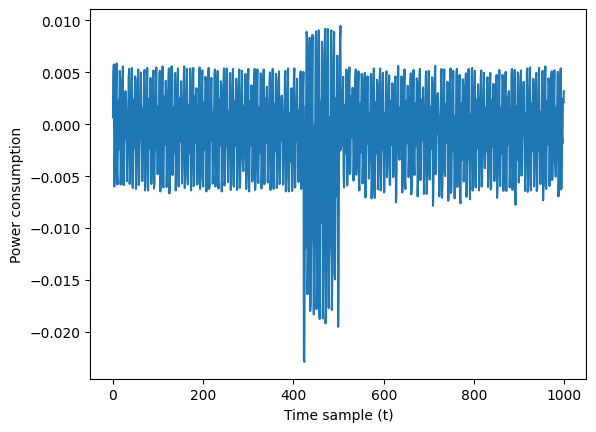

In [193]:
# Average all traces to reduce noise
avg_trace = np.mean(traces, axis=0)

# Plot the averaged trace
plt.plot(avg_trace)
plt.xlabel("Time sample (t)")
plt.ylabel("Power consumption")
plt.show()

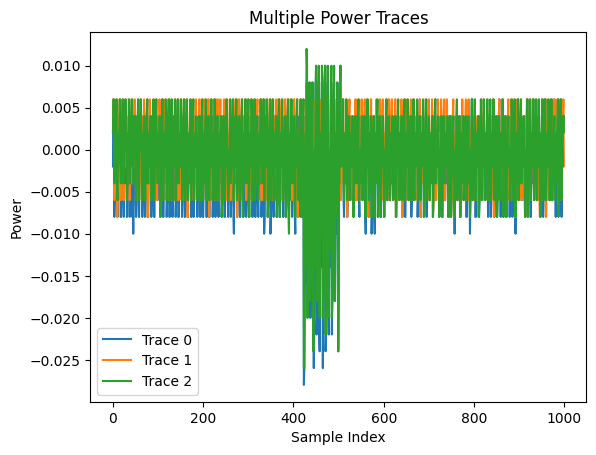

In [194]:
# multiple traces
for i in range(3):  # Plot first 2 traces
    plt.plot(traces[i], label=f"Trace {i}")
plt.legend()
plt.title("Multiple Power Traces")
plt.xlabel("Sample Index")
plt.ylabel("Power")
plt.show()

[INFO] Calculating NSR for 42 traces with 190 samples each
[RESULT] Overall NSR (linear): 9.269386
[RESULT] Overall NSR (dB): 9.67 dB
[RESULT] Overall SNR (linear): 0.107882
[RESULT] Overall SNR (dB): -9.67 dB


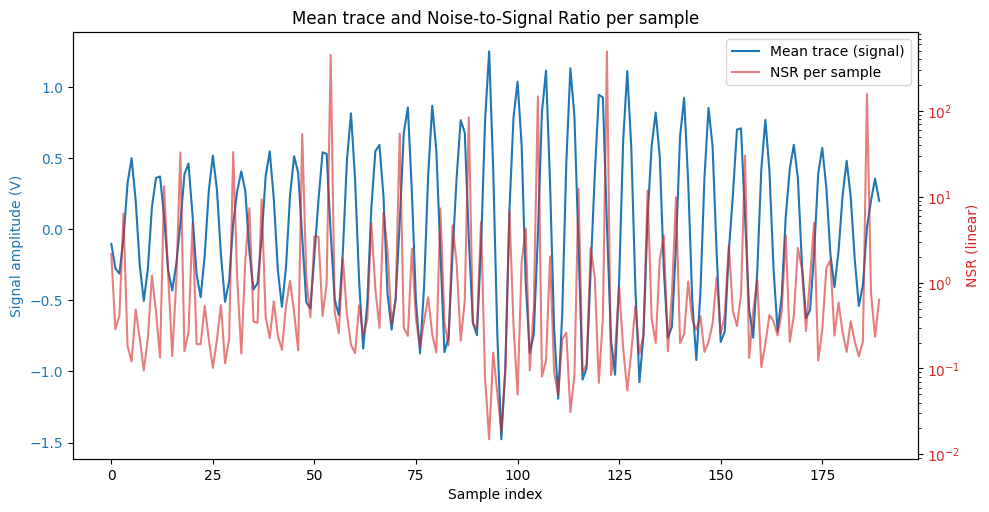

In [177]:
def compute_and_plot_nsr(traces: np.ndarray, save_path: str | None = None):
    """
    Compute noise-to-signal ratio (NSR) for a set of aligned traces, and plot results.
    
    Parameters
    ----------
    traces : np.ndarray
        2D array of shape (n_traces, n_samples) containing aligned, scaled traces in volts.
    save_path : str or None
        If provided, path to save the plot (PNG). If None, plot is just shown.
    
    Returns
    -------
    nsr_per_sample : np.ndarray
        NSR (noise variance / signal variance) for each sample index.
    overall_nsr : float
        Average NSR across all sample points (linear scale).
    """
    if traces.ndim != 2:
        raise ValueError("Expected traces as 2D array (n_traces, n_samples)")

    n_traces, n_samples = traces.shape
    print(f"[INFO] Calculating NSR for {n_traces} traces with {n_samples} samples each")

    # Step 1: Compute the deterministic signal = mean waveform
    mean_trace = np.mean(traces, axis=0)

    # Step 2: Compute signal variance (variance of mean trace over time)
    # Note: Here "signal variance" is computed across time, not across traces
    signal_variance_per_sample = mean_trace**2  # squared mean = power at each point

    # Step 3: Compute noise variance = mean over traces of (trace - mean_trace)^2
    noise_variance_per_sample = np.mean((traces - mean_trace)**2, axis=0)

    # Step 4: NSR = noise variance / signal variance (avoid div-by-zero)
    # If signal variance is 0, set NSR to np.inf (pure noise)
    with np.errstate(divide='ignore', invalid='ignore'):
        nsr_per_sample = np.where(signal_variance_per_sample > 0,
                                  noise_variance_per_sample / signal_variance_per_sample,
                                  np.inf)

    # Step 5: Compute overall NSR (mean over samples, ignoring infinities)
    finite_nsr = nsr_per_sample[np.isfinite(nsr_per_sample)]
    overall_nsr = np.mean(finite_nsr)
    overall_snr = 1.0 / overall_nsr if overall_nsr != 0 else np.inf

    # Print results in linear and dB scale
    print(f"[RESULT] Overall NSR (linear): {overall_nsr:.6f}")
    print(f"[RESULT] Overall NSR (dB): {10*np.log10(overall_nsr):.2f} dB")
    print(f"[RESULT] Overall SNR (linear): {overall_snr:.6f}")
    print(f"[RESULT] Overall SNR (dB): {10*np.log10(overall_snr):.2f} dB")

    # Step 6: Plot
    fig, ax1 = plt.subplots(figsize=(10, 5))
    t_axis = np.arange(n_samples)  # sample index; replace with time scale if available

    color_signal = 'tab:blue'
    color_nsr = 'tab:red'

    ax1.set_xlabel("Sample index")
    ax1.set_ylabel("Signal amplitude (V)", color=color_signal)
    ax1.plot(t_axis, mean_trace, color=color_signal, label="Mean trace (signal)")
    ax1.tick_params(axis='y', labelcolor=color_signal)

    ax2 = ax1.twinx()
    ax2.set_ylabel("NSR (linear)", color=color_nsr)
    ax2.plot(t_axis, nsr_per_sample, color=color_nsr, alpha=0.6, label="NSR per sample")
    ax2.tick_params(axis='y', labelcolor=color_nsr)
    ax2.set_yscale('log')  # log scale helps visualize small and large NSR

    fig.tight_layout()
    plt.title("Mean trace and Noise-to-Signal Ratio per sample")

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

    if save_path:
        plt.savefig(save_path, dpi=150)
        print(f"[INFO] NSR plot saved to {save_path}")
    else:
        plt.show()

    return nsr_per_sample, overall_nsr

# usage:
nsr_curve, avg_nsr = compute_and_plot_nsr(traces)


In [178]:
# Create a dummy key of the same length
key_placeholder = bytearray(16)

# Create the CW project and append traces
# Make sure the 'data/traces_1' directory exists
if not os.path.exists("data/traces_1"):
    os.makedirs("data/traces_1")
    
proj = cw.create_project("data/traces_1/CW_305.cwp", overwrite=True)

print("Processing and appending traces to the project...")
for i, (trace, pt, ct) in enumerate(zip(traces, plaintexts, ciphertexts)):
    # Sanity check: ensure all blocks have the correct fixed length
    assert len(pt) == 16 and len(ct) == 16, \
           f"Trace {i}: Got pt/ct lengths {len(pt)}/{len(ct)}, expected {16}"
           
    proj.traces.append(cw.Trace(trace, pt, ct, key_placeholder))

print(f"Successfully processed {len(proj.traces)} traces.")
#proj.save()  # save the project for later use


Processing and appending traces to the project...
Successfully processed 42 traces.


In [179]:
lengths = [len(t) for t in proj.traces[0]]  # Each trace as a 1D array/list
print("Trace lengths:", lengths)
print("Unique lengths:", set(lengths))

Trace lengths: [190, 16, 16, 16]
Unique lengths: {16, 190}


In [180]:
print("Instantiating and running CPA attack...")
# Set leakage model:
leak_model = cwa.leakage_models.last_round_state_diff
# Instantiate and run CPA
attack = cwa.cpa(proj, leak_model)
cb = cwa.get_jupyter_callback(attack)
best_guesses = attack.run(cb)

print("\n--- Attack Results ---")
print("Recovered key-byte guesses:", best_guesses)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
PGE=,86,24,174,245,42,89,6,104,119,111,209,98,8,68,161,104
0,DB0.782,6F0.778,780.756,970.759,EF0.743,190.722,D00.739,E70.761,340.742,C40.706,F70.745,AF0.778,810.754,2F0.731,B90.815,D00.726
1,BE0.739,CD0.721,870.735,A40.731,F80.729,E60.701,400.714,A70.715,B10.728,070.698,080.717,8A0.702,180.741,AA0.700,F70.780,BC0.724
2,940.704,AB0.700,3A0.695,DC0.711,E50.716,430.683,370.692,E50.686,430.698,7A0.692,100.705,A60.670,5B0.726,870.674,A40.687,810.704
3,4C0.695,C70.692,210.695,450.707,C30.680,910.680,EF0.666,2D0.656,130.696,200.691,580.669,1E0.659,420.715,160.673,A80.650,F90.701
4,6F0.688,260.687,800.668,A80.702,BC0.668,3C0.671,3A0.664,F00.655,A60.695,630.685,D60.662,9A0.658,DA0.694,7B0.673,380.630,650.695



--- Attack Results ---
Recovered key-byte guesses: Subkey KGuess Correlation
  00    0xDB    0.78233
  01    0x6F    0.77805
  02    0x78    0.75584
  03    0x97    0.75928
  04    0xEF    0.74294
  05    0x19    0.72154
  06    0xD0    0.73937
  07    0xE7    0.76124
  08    0x34    0.74245
  09    0xC4    0.70618
  10    0xF7    0.74509
  11    0xAF    0.77757
  12    0x81    0.75418
  13    0x2F    0.73088
  14    0xB9    0.81546
  15    0xD0    0.72642



In [181]:
recv_lastroundkey = [kguess[0][0] for kguess in best_guesses.find_maximums()]
recv_key = key_schedule_rounds(recv_lastroundkey, 10, 0)
for subkey in recv_key:
    print(hex(subkey), end="")

0xdb0xfd0x490x260x200xa80xb0x680xd40x790x4c0xff0x200xe50x440x1